In [45]:
import sqlite3
import pandas as pd
import plotly.express as px
import sys
import plotly.graph_objects as go

sys.path.append('../')
from functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.options.mode.chained_assignment = None

In [46]:
# Years
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)

df_ind_year = df_ind[["individual_wikidata_id", "birthyear", "individual_name"]].drop_duplicates()
df_ind_year = df_ind_year[~df_ind_year['birthyear'].isna()]
df_ind_year["productive_year"] = df_ind_year["birthyear"] + 35
temporal_resolution = 50
df_ind_year["decade"] = df_ind_year["productive_year"].apply(lambda x: round(x / temporal_resolution) * temporal_resolution)
df_ind_year = df_ind_year[df_ind_year['decade']<=1850]


# Individuals Regions
df_ind_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_ind_regions = df_ind_regions[['individual_wikidata_id', 'region_name']].drop_duplicates()


In [47]:
df_catalogs_id = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)

In [48]:
df_catalogs_counts = df_catalogs_id.groupby('individual_wikidata_id')['identifiers_wikidata_id'].count().reset_index()
df_catalogs_counts = df_catalogs_counts.sort_values('identifiers_wikidata_id', ascending=False)

In [49]:
df_final = pd.merge(df_ind_year, df_catalogs_counts, on = 'individual_wikidata_id')

region_name =  'Chinese world'
min_date = -500
max_date = 1850

df_reg_fil = df_ind_regions[df_ind_regions['region_name']==region_name]

df_final = pd.merge(df_final, df_reg_fil, on = 'individual_wikidata_id')
df_final = df_final[df_final['decade']>=min_date]
df_final = df_final[df_final['decade']<=max_date]

In [50]:
df_ids = df_final[['individual_wikidata_id', 'identifiers_wikidata_id']].sort_values('identifiers_wikidata_id', ascending=False)
num = int(round(len(df_ids)*0.2, 0))
top_20 = df_ids.head(num)

num = int(round(len(df_ids)*0.2, 0))
bottom_20 = df_ids.tail(num)

sample_20 = df_ids.sample(num, random_state=42)

In [51]:
df_top_20 = df_final[df_final['individual_wikidata_id'].isin(list(top_20.individual_wikidata_id))]
df_top_20['type'] = 'top_20%'
df_bottom_20 = df_final[df_final['individual_wikidata_id'].isin(list(bottom_20.individual_wikidata_id))]
df_bottom_20['type'] = 'bottom_20%'
df_sample_20 = df_final[df_final['individual_wikidata_id'].isin(list(sample_20.individual_wikidata_id))]
df_sample_20['type'] = 'sample_20%'

df_concat = pd.concat([df_top_20, df_bottom_20, df_sample_20])
df_concat = df_concat.reset_index(drop=True)
df_concat

,individual_wikidata_id,birthyear,individual_name,productive_year,decade,identifiers_wikidata_id,region_name,type
0,Q203782,813.0,Li Shangyin,848.0,850,48,Chinese world,top_20%
1,Q597003,1794.0,Wei Yuan,1829.0,1850,31,Chinese world,top_20%
2,Q25251,1683.0,Dalai Lama 06 Tsangyang Gyatso,1718.0,1700,45,Chinese world,top_20%
3,Q19133,1711.0,Qianlong Emperor,1746.0,1750,66,Chinese world,top_20%
4,Q548603,1284.0,Karmapa 03,1319.0,1300,21,Chinese world,top_20%
...,...,...,...,...,...,...,...,...
1285,Q45698926,1736.0,Bao Zhilan,1771.0,1750,4,Chinese world,sample_20%
1286,Q45598851,1794.0,Qu Ning,1829.0,1850,2,Chinese world,sample_20%
1287,Q7967522,1835.0,Wang Laiquan,1870.0,1850,2,Chinese world,sample_20%
1288,Q2585778,1496.0,Lu Zhi,1531.0,1550,29,Chinese world,sample_20%


In [52]:
df_fig = df_concat.groupby(['type', 'decade'])['individual_wikidata_id'].count().reset_index()
df_fig

,type,decade,individual_wikidata_id
0,bottom_20%,-450,1
1,bottom_20%,-350,1
2,bottom_20%,-250,1
3,bottom_20%,-200,2
4,bottom_20%,-150,1
...,...,...,...
122,top_20%,1650,46
123,top_20%,1700,37
124,top_20%,1750,33
125,top_20%,1800,20


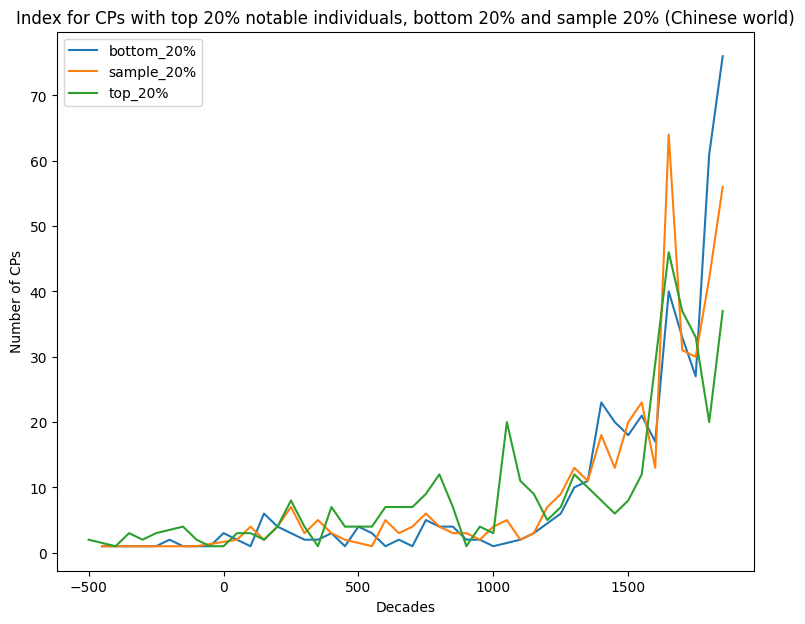

In [53]:
import matplotlib.pyplot as plt


# Plot a line for each creation year category
plt.figure(figsize=(9, 7))

for var, group in df_fig.groupby('type'):
    plt.plot(group['decade'], group['individual_wikidata_id'], label=var)

plt.title(f'Index for CPs with top 20% notable individuals, bottom 20% and sample 20% ({region_name})')
plt.xlabel('Decades')
plt.ylabel('Number of CPs')
plt.legend()
plt.grid(False)

plt.savefig('figures/wikidata_stats/evolution_with_notable_individuals.png', dpi = 200)
plt.show()

In [54]:
df_corr = df_fig.pivot(index = "decade", columns = "type", values = 'individual_wikidata_id')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.9005979559475503

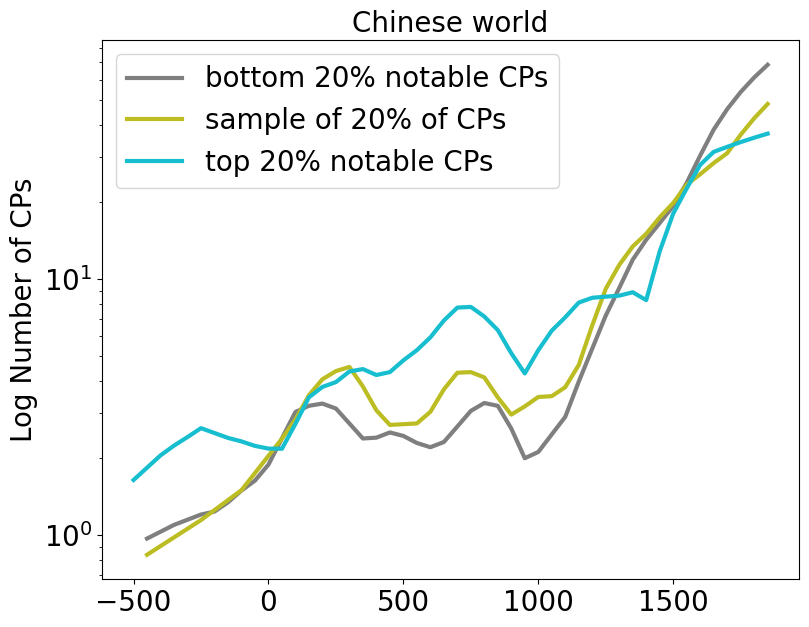

In [56]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Assuming df_fig and region_name are already defined in your code
# Also assuming that 'type' column in df_fig contains 'bottom_20%', 'sample_20%', 'top_20%'

# Professional, colorblind-friendly color palette
colors = ['tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(9, 7))

# Create a dictionary to map the 'type' to a more readable form
legend_rename = {'bottom_20%': 'bottom 20% notable CPs',
                 'sample_20%': 'sample of 20% of CPs',
                 'top_20%': 'top 20% notable CPs'}

for (var, group), color in zip(df_fig.groupby('type'), colors):
    # Prepare data for LOESS
    x = group['decade']
    y = group['individual_wikidata_id']

    # Fit LOESS model (you can adjust the fraction as needed for smoothing)
    loess = sm.nonparametric.lowess(y, x, frac=0.2)

    # Increase the linewidth for thicker lines
    # Use the legend_rename dictionary to get a more readable label
    plt.plot(loess[:, 0], loess[:, 1], label=legend_rename[var], linewidth=3, color=color)

plt.title(f'{region_name}', size=20)
plt.xlabel('')
plt.ylabel('Log Number of CPs', size=20)
plt.yscale('log')
plt.legend(prop={'size': 20})

# Increase the size of the x-tick and y-tick labels
plt.tick_params(axis='x', labelsize=20)  # Adjust x-tick label size
plt.tick_params(axis='y', labelsize=20)  # Adjust y-tick label size

plt.grid(False)

plt.savefig('figures/wikidata_stats/evolution_with_notable_individuals_china.png', dpi=300)
plt.show()
